(https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Cassandra1.jpeg/800px-Cassandra1.jpeg)
## Notebook to run serial methods

With this notebook you can run live/backtest Kaissandra, plot live results and much more

In [67]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")
    
import pandas as pd
import datetime as dt
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ already in python path


## Build table with all positions in one session

In [60]:
def get_positions_filename(asset, open_dt, close_dt):
    """  """
    
    dt_open = dt.datetime.strftime(dt.datetime.strptime(
            open_dt,'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    dt_close = dt.datetime.strftime(dt.datetime.strptime(
            close_dt,'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    filename = 'O'+dt_open+'C'+dt_close+asset
    return filename

In [72]:
start_time = '19_01_27_14_08_06'
results_dir = '../../RNN/resultsLive/back_test/trader/'
positions_dir = '../../RNN/resultsLive/back_test/positions/'+start_time+'/'
filename = results_dir+start_time+'_BT_'+"positions_soll.log"
positions = pd.read_csv(filename).sort_values(by=['Entry Time']).reset_index().drop(labels='index',axis=1)

In [73]:
print(positions.to_string())

    Asset           Entry Time            Exit Time  Position       Bi       Ai       Bo       Ao  ticks_d      GROI    Spread       ROI    Profit  E_spread  stoploss    stGROI     stROI
0  GBPJPY  2018.03.09 00:16:24  2018.03.09 00:25:09         2  146.658  146.765  146.660  146.745        0 -0.013627  0.057916 -0.071543 -7.154294  0.068818         0 -0.013627 -0.071543
1  EURJPY  2018.03.09 00:20:52  2018.03.09 00:26:26         1  130.739  130.813  130.774  130.833        0  0.015289  0.045103 -0.029814 -2.981355  0.056569         0  0.001662 -0.101356
2  CADJPY  2018.03.09 00:22:28  2018.03.09 00:33:30        -1   82.313   82.375   82.342   82.390        0 -0.035198  0.058259 -0.093458 -9.345794  0.070409         0 -0.033537 -0.194814


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


{'p_mds': [0.564984142780304, 0.564984142780304, None], 'dts': ['2018.03.09 00:16:24', '2018.03.09 00:20:08', '2018.03.09 00:25:09'], 'levels': [2, 2, None], 'n_ext': 1, 'grois': [0.0, -6.8136135998116255e-06, -0.000136272271999331], '@tick#': [0, 900, 1900], 'p_mcs': [0.6994259357452393, 0.6994259357452393, None], 'id': 0}
{'p_mds': [0.6918656229972839, None], 'dts': ['2018.03.09 00:20:52', '2018.03.09 00:26:26'], 'levels': [1, None], 'n_ext': 0, 'grois': [0.0, 0.0001528900032872133], '@tick#': [0, 1000], 'p_mcs': [0.5717154145240784, None], 'id': 0}
{'p_mds': [0.629414439201355, 0.629414439201355, 0.629414439201355, None], 'dts': ['2018.03.09 00:22:28', '2018.03.09 00:23:28', '2018.03.09 00:25:15', '2018.03.09 00:33:30'], 'levels': [-1, -1, -1, None], 'n_ext': 2, 'grois': [0.0, 0.00027931264800529643, -6.069729047289808e-05, -0.0003519844641339527], '@tick#': [0, 100, 500, 1500], 'p_mcs': [0.5394558310508728, 0.5394558310508728, 0.5394558310508728, None], 'id': 0}
    asset          

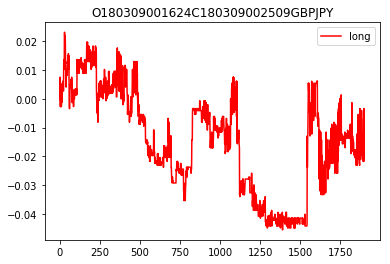

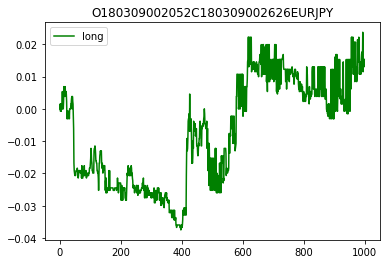

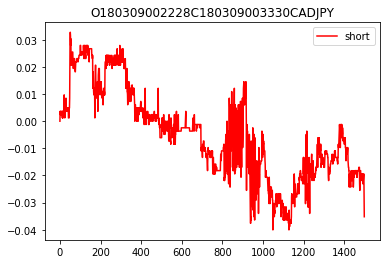

In [79]:
columns = ['asset','Di','Ti','Do','To','direction','groi','roi','profit','e_spread','spread','max','min','argmax','argmin','samples','extensions','stoploss','file']
pos_format = pd.DataFrame(data=0,columns=columns,index=range(positions.shape[0]))
plt_index = 0
for p in range(positions.shape[0]):
    #print(positions.iloc[p])
    pos_format['asset'].iloc[p] = positions['Asset'].iloc[p]
    pos_format['Di'].iloc[p] = positions['Entry Time'].iloc[p][:10]
    pos_format['Ti'].iloc[p] = positions['Entry Time'].iloc[p][11:]
    pos_format['Do'].iloc[p] = positions['Exit Time'].iloc[p][:10]
    pos_format['To'].iloc[p] = positions['Exit Time'].iloc[p][11:]
    pos_format['groi'].iloc[p] = positions['GROI'].iloc[p]
    pos_format['roi'].iloc[p] = positions['ROI'].iloc[p]
    pos_format['e_spread'].iloc[p] = positions['E_spread'].iloc[p]
    pos_format['spread'].iloc[p] = positions['Spread'].iloc[p]
    pos_format['profit'].iloc[p] = positions['Profit'].iloc[p]
    pos_format['stoploss'].iloc[p] = positions['stoploss'].iloc[p]
    direction = positions['Position'].iloc[p]
    pos_format['direction'].iloc[p] = direction
    filename = get_positions_filename(positions['Asset'].iloc[p], positions['Entry Time'].iloc[p], positions['Exit Time'].iloc[p])
    pos_format['file'].iloc[p] = filename
    pos_ev = pd.read_csv(positions_dir+filename+'.txt', sep=',')
    pos_track = pickle.load( open( positions_dir+filename+".p", "rb" ))
    print(pos_track)
    pos_format['extensions'].iloc[p] = pos_track['n_ext']
    pos_format['samples'].iloc[p] = pos_ev.shape[0]
    #print(pos_ev.columns)
    maxBid = pos_ev['SymbolBid'].max()
    minBid = pos_ev['SymbolBid'].min()
    maxAsk = pos_ev['SymbolAsk'].max()
    minAsk = pos_ev['SymbolAsk'].min()
    Bi = positions['Bi'].iloc[p]
    Ai = positions['Ai'].iloc[p]
    #if direction>0:
    #        GROI_live = roi_ratio*(Ao-Ai)/Ai
    #        spread = (Ao-Bo)/Ai
    #        
    #    else:
    #        GROI_live = roi_ratio*(Bi-Bo)/Ao
    if direction>0:
        pos_format['max'].iloc[p] = 100*(maxAsk-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        pos_format['min'].iloc[p] = 100*(minAsk-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        pos_format['argmax'].iloc[p] = pos_ev['SymbolAsk'].idxmax()
        pos_format['argmin'].iloc[p] = pos_ev['SymbolAsk'].idxmin()
        groi_ev = 100*(pos_ev['SymbolAsk'].iloc[:]-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        label = 'long'
    else:
        pos_format['max'].iloc[p] = 100*(positions['Bi'].iloc[p]-minBid)/maxAsk
        pos_format['min'].iloc[p] = 100*(positions['Bi'].iloc[p]-maxBid)/maxAsk
        pos_format['argmax'].iloc[p] = pos_ev['SymbolBid'].idxmax()
        pos_format['argmin'].iloc[p] = pos_ev['SymbolBid'].idxmin()
        groi_ev = 100*(positions['Bi'].iloc[p]-pos_ev['SymbolBid'].iloc[:])/pos_ev['SymbolAsk'].iloc[:]
        label = 'short'
    if positions['GROI'].iloc[p]>0:
        color = 'green'
    else:
        color = 'red'
    plt.figure(plt_index)
    plt.plot(groi_ev, color=color, label=label)
    plt.legend()
    plt.title(filename)
    plt_index += 1
print(pos_format.to_string())

In [ ]:
pos_ev['SymbolBid'].iloc[:0]

## Plot positions

## Run online

In [ ]:
# runLive in multiple processes
from multiprocessing import Process
from runLive import run
import datetime as dt
import time

assets = [1, 2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 16, 17, 19, 27, 28, 29, 30, 31, 32]#
running_assets = assets#[7, 14]
start_time = dt.datetime.strftime(dt.datetime.now(),'%y_%m_%d_%H_%M_%S')
#disp = Process(target=run, args=[running_assets,start_time])
#disp.start()
for ass_idx in range(len(running_assets)):
    disp = Process(target=run, args=[running_assets[ass_idx:ass_idx+1],start_time])
    disp.start()
    time.sleep(2)

## Get total returns

In [ ]:
import pandas as pd
start_time = '18_12_10_10_53_20'
results_dir = '../RNN/resultsLive/back_test/trader/'
filename = results_dir+start_time+'_LI_'+"positions_soll.log"
positions = pd.read_csv(filename)
print(positions.GROI.sum())
print(positions.ROI.sum())
print(positions.Profit.sum())
print(positions.Profit)